In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

The model for the MLP is the same as in the paper. Two input neurons, a hidden layer with 500 units and an output layer with 784 units. We choose the ReLU activation function.

In [2]:
class MultilayerPerceptron(nn.Module):
    """
    A MLP with 1 hidden layer
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        """
    Constructor of the MLP.
    Arguments:
    - input_size : number of neurons in the first layer 
    (aka latent space dimension)
    - hidden_size : number of neurons in the hidden layer
    - outout_size : number of neurons in the last layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.hidden = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        # self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        hidden = self.hidden(x)
        relu = self.relu(hidden)
        output = self.output(relu)
        output = self.sigmoid(output)
        # output = self.relu(output)
        return output
    

In [3]:
test = MultilayerPerceptron(2, 500, 784)
print(test)

MultilayerPerceptron(
  (hidden): Linear(in_features=2, out_features=500, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=500, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)


In [4]:
x = torch.rand(2, requires_grad=True)
y_random = test.forward(x)

In [5]:
def imshow(img):
    """
    takes a tensor as input and returns an image
    """
    
    np_img = img.detach().numpy()
    plt.imshow(np.reshape(np_img,(28,28)), cmap='gray_r' )
    plt.show()

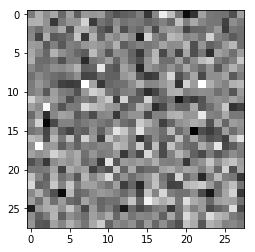

In [6]:
# for i in range(10):
#     imshow(test.forward(x[i,:]))
imshow(test.forward(x))

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


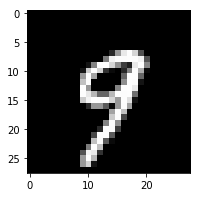

In [7]:
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)



# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

dataiter = iter(train_loader)
images, labels = dataiter.next()

images_np = images.numpy()


# get one image from the batch
img = np.squeeze(images_np[np.random.randint(len(images))])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.show()

In [8]:
img_test = images[0]

In [9]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(test.parameters(), lr = 0.01)

In [10]:
test.train()
epoch = 10000
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = test(x)
    # Compute Loss
    loss = criterion(y_pred, img_test)
   
    # print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

/Users/Gabriel/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([784])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [11]:
test.eval()
y_pred = test(x)

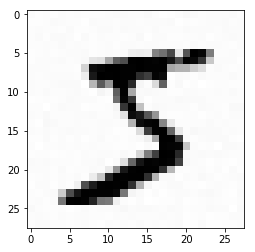

In [12]:
imshow(y_pred)

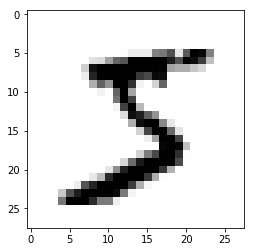

In [13]:
# for i in range(10):
#     imshow(img_test[i])
imshow(img_test)

In [102]:
def cost_matrix(x, y):
    """
    computes the cost matrix between two tensors
    each entry is the pairwise squared distance.
    
    tensors have been flattened beforehand
    
    ultra costly to compute, must be optimized
    """
    
    x_lin = x.view(1, -1)
    y_lin = y.view(1, -1)
    
    d, p = x_lin.size()[1], y_lin.size()[1]
    
    # initialize the cost matrix
    C = torch.zeros([d,p])
    
    # populate each entry
    for i in range(d):
        for j in range(p):
            C[i,j] += (x_lin[0,i]- y_lin[0,j])**2
            
    return C  


def sinkhorn_wasserstein(x, y, C, epsilon=0.1, max_iters = 100):
    """
    uses sinkhorn algorithm to approximate the optimal
    transport plan between two input measures x and y.
    
    computes the cost matrix (l2 norm) and alternate
    projections to compute the 
    """
    
    # reshape the input tensors
    x_lin = x.view(1,-1)
    y_lin = y.view(1,-1)
        
    # Compute the kernel matrix K
    K = torch.exp(-C/epsilon)
    
    # Alternate projections
    v = torch.ones(x_lin.size()[1])
    
    for _ in range(max_iters):
        u = x_lin / torch.mv(K,v)
        u = u.squeeze()
        v = y_lin / torch.mv(K.t(),u)
        v = v.squeeze()
        
    diag_u = torch.diag(u)
    diag_v = torch.diag(v)
    u_dot_K = torch.mm(diag_u,K)
    
    # Approximation of the optimal transport plan
    P_L = torch.mm(u_dot_K,diag_v)
    
    # Approximation of the Wasserstein Loss
    W_L = torch.trace(torch.mm(P_L.t(),C))

    return W_L

In [106]:
def sinkhorn_loss(x,y, epsilon = 0.1, max_iters = 100):
    """
    wrapper of the two functions
    """
    
    # costs
    C_xx = cost_matrix(x,x)
    C_xy = cost_matrix(x,y)
    C_yy = cost_matrix(y,y)
    
    # Wasserstein losses
    W_xx = sinkhorn_wasserstein(x,x, C_xx, epsilon = epsilon, max_iters = max_iters)
    W_xy = sinkhorn_wasserstein(x,y, C_xy, epsilon = epsilon, max_iters = max_iters)
    W_yy = sinkhorn_wasserstein(y,y, C_yy, epsilon = epsilon, max_iters = max_iters)
    
    # Return the sinkhorn loss
    return 2 * W_xy - W_xx - W_yy


In [ ]:
a = sinkhorn_loss(img_test, y_pred)
b = sinkhorn_loss(img_test, y_random)

In [ ]:
print(a)
print(b)

In [ ]:
# ce qu'on doit faire en théorie (tout simplement en fait)
# cependant pas avec une observation mais un batch assez conséquent (pour avoir une meilleure approx des
# mesures empiriques)

test.train()

epoch = 1
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = test(x)
    # Compute Loss
    loss = sinkhorn_loss(y_pred, img_test)
   
    # print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()